# Here we reconstruct images using our GAN
The first step is to train a neural net to decode pictures into their correct SRM representation. I.E. we have to go from image -> embedding. Instead of using raw images, lets use the image embedding constructed by mobilenet. 

In [1]:
import brainiak.funcalign.srm
from scipy import stats
from sklearn import svm
import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import argparse
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import models, transforms
from pytorch_pretrained_biggan import (BigGAN, one_hot_from_names, truncated_noise_sample)

Here we define the pytorch lightning code to do this. 

We will need the vectorizer defined in part4. 

In [2]:
class image2Vec(nn.Module):
    def __init__(self):
        super().__init__()
        # Here is mobile net
        self.model = models.mobilenet_v3_small(pretrained=True).to('cuda')
        self.featureLayer = self.model._modules.get('classifier')[3] # Corresponds to the second last layer
        
        # Using tricks to copy the ouput of the second last layer
        self.featureLayer.register_forward_hook(self.hook)
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    def hook(self, m, i, o):
        self.embed = i
        
    def forward(self, x):
        if not x.is_cuda:
            x = x.to('cuda')
        x = self.normalize(x)
        self.model(x)

        return self.embed[0]

In [ ]:
class DataModule(pl.LightningDataModule):
    @staticmethod
    def get_HP(args=[]):
        parser = argparse.ArgumentParser(description='Define model Hyperparams')
        root_dir = os.getcwd()
        parser.add_argument('--embed_size', default=300)
        parser.add_argument('--y_train', default=os.path.join(root_dir, 'np_data/300_SRM_all_subs_train.npy'), type=str)
        parser.add_argument('--y_test', default=os.path.join(root_dir, 'np_data/300_SRM_all_subs_test.npy'), type=str)
        parser.add_argument('--X_train', default=os.path.join(root_dir, 'np_data/all_sub_images_train.npy'), type=str)
        parser.add_argument('--X_test', default=os.path.join(root_dir, 'np_data/all_sub_images_test.npy'), type=str)
        parser.add_argument('--data_dir', default=os.path.join(root_dir, 'data/Encoder'), type=str)
        return parser.parse_args(args = args)
    
    def __init__(self, HP):
        super().__init__()
        self.HP = HP

    # For one time preprocessing of data
    def prepare_data(self):
        try: # Check if the data has already been preprocessed
            temp = torch.load(self.HP.data_dir + '/test.h5'); del temp;
        except:
            X_train = np.load(self.HP.X_train)
            y_train = np.load(self.HP.y_train)
            X_test = np.load(self.HP.X_test)
            y_test = np.load(self.HP.y_test)

            # Creating the dataset
            y_train = torch.reshape(torch.Tensor(y_train), (-1, self.HP.embed_size)) # transform to torch tensor
            y_test = torch.reshape(torch.Tensor(y_test), (-1, self.HP.embed_size)) 
            
            #ims train
            X_train_resized = []
            for img in X_train:
                img = Image.fromarray(img)
                img = img.resize((224, 224), Image.BICUBIC)
                X_train_resized.append(np.array(img).transpose(2, 0, 1))
            X_train = torch.Tensor(np.stack(X_train_resized, axis=0))
        
            #ims test
            X_test_resized = []
            for img in X_test:
                img = Image.fromarray(img)
                img = img.resize((224, 224), Image.BICUBIC)
                X_test_resized.append(np.array(img).transpose(2, 0, 1))
            X_test = torch.Tensor(np.stack(X_test_resized, axis=0))
            if not os.path.exists(self.HP.data_dir):
                os.mkdir(self.HP.data_dir)
            torch.save({"X": X_train, "y": y_train}, self.HP.data_dir + '/train.h5')
            torch.save({"X": X_test, "y": y_test}, self.HP.data_dir + '/test.h5')    

    def setup(self, stage=None):
        train = torch.load(self.HP.data_dir + '/train.h5')
        self.train_ds = TensorDataset(train["X"], train["y"])
        test = torch.load(self.HP.data_dir + '/test.h5')
        self.test_ds = TensorDataset(test["X"], test["y"])
        
    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=64, pin_memory=True, shuffle=True) # create your dataloader

    def val_dataloader(self):
        return DataLoader(self.test_ds, batch_size=64, shuffle=True) # create your dataloader
    
    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=10, shuffle=True) # create your dataloader
    

        
class Encoder(pl.LightningModule):
    @staticmethod
    def get_HP(args = []):
        parser = argparse.ArgumentParser(description='Define model Hyperparams')
        parser.add_argument('--embed_size', default = 300)
        return parser.parse_args(args = args)
    
    def __init__(self, HP):
        super().__init__()
        self.HP = HP
        self.save_hyperparameters()
        self.model = models.resnet18(pretrained=True)
        in_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(in_ftrs, HP.embed_size)
        self.normalize = transforms.Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225]
                )

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
        return optimizer
    
    def forward(self, x):
        return self.model(self.normalize(x))
    
    def training_step(self, batch, batch_idx):
        ims, SRM = batch
        encoding = self(ims)
        loss = F.mse_loss(encoding, SRM)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        fmri, ims = batch
        gen = self(fmri)
        loss = F.mse_loss(gen, ims)
        self.log('val_loss', loss, prog_bar=True)
    
    def test_step(self, batch, batch_idx):
        fmri, ims = batch
        gen = self(fmri)
        loss = F.mse_loss(gen, ims)
        self.predictions = gen
        self.targets = ims
        self.log('test_loss', loss)  


early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0,
   patience=0,
   verbose=False,
   mode='min'
)    

# saves a file like: my/path/sample-mnist-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    save_last=True,
    save_top_k=1,
    mode='min',
    monitor='val_loss',
    filename='nueroImg-{epoch:02d}-{train_loss:.4f}'
)

dm_HP = DataModule.get_HP()
dm = DataModule(dm_HP)

# """
# Running our model
# """


model_HP = Encoder.get_HP()
model = Encoder(model_HP)

trainer = pl.Trainer(max_epochs=100, gpus=1, callbacks=[checkpoint_callback, early_stop_callback])
trainer.fit(model, dm)

We have now trained an encoder which takes images into brainspace using a neural net. Unfortunately, I have not been able to get this neural net to converge yet. It stagnates at 1 which is most likely can be achieved by randomly sampling from a distribution with variance 1. Clearly, there is still debugging and fine tuning to do. Given that in the previous notebook we were able to do some image reconstruction from brain data, we certainly should be able to do some brain data reconstruction from image data. 

Now performing the final step:

We will need our searcher again to find a good input. 

In [5]:
# here is our model which generates images in the hope of matching an encoding produced by our SRM
class searchGAN(nn.Module):
    def __init__(self, GAN, encoder):
        super().__init__()
        # 7 linear units in a row seems to do quite well in searching
        self.searcher = nn.ModuleList()
        for i in range(7):
            self.searcher.extend([
                    nn.Linear(128, 128), 
                    nn.ELU(),
            ])
        self.searcher = nn.Sequential(*self.searcher)
        self.pre_trained_GAN = GAN
        self.encoder = encoder
        self.transform = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    
    def forward(self, x, label, trunc):
        x = self.searcher(x)
        # Here is our static pretrained GAN
        img = self.pre_trained_GAN(x, label, trunc)
        embedding = self.encoder(self.transform(img))
        return img, embedding
    

Defining some helper functions

In [10]:
def process_img(np_img):
    img = Image.fromarray(np_img)
    img = img.resize((224, 224), Image.BICUBIC)
    img = torch.Tensor(np.array(img).transpose(2, 0, 1)).unsqueeze(0)
    return img

def show_images(im_batch):
    ims = np.transpose(im_batch.detach().numpy(), (0, 2, 3, 1))
    ims = (ims - np.min(ims)) / (np.max(ims) - np.min(ims))
    R = int(len(ims[0])/2+1)
    C = 2
    plt.figure(figsize=(4, 200))
    for i in range(len(ims)):
        plt.subplot(R, C, i+1)
        plt.axis('off')
        plt.imshow(ims[i], interpolation='bilinear')
    plt.show()


# Loading the ims to be searched
ims = np.load('np_data/all_sub_images_test.npy')
SRM = np.load('np_data/300_SRM_all_subs_test.npy')

# Defining our encoder
encoder = Encoder.load_from_checkpoint('lightning_logs/version_17634246/checkpoints/last.ckpt')
# Freezing params in our encoder
for param in encoder.parameters():
    param.requires_grad = False
    
# Defining our GAN
bGAN = BigGAN.from_pretrained('biggan-deep-256')
# Freezing params in our GAN
for param in bGAN.parameters():
    param.requires_grad = False

And here is the main traning loop where we try to find a good match for the encoded image:

In [ ]:
n_epochs = 500
generator = searchGAN(bGAN, encoder).to('cuda') # Resetting the model 
optimizerG = torch.optim.Adam(generator.parameters(), lr = 3e-5)
criterion = nn.MSELoss()

class_vector = torch.zeros((1, 1000)).to('cuda')
latent = torch.ones((1, 128)).to('cuda')

# Defining our target
target = ims[50]
embed_real = torch.Tensor(SRM[50]).unsqueeze(0).to('cuda')
truncation = 1

for epoch in range(n_epochs):
    generator.zero_grad()
    img, embed_fake = generator(latent, class_vector, truncation)
    loss = criterion(embed_fake, embed_real)
    loss.backward()
    optimizerG.step()
    if epoch%50 == 0:
        print("loss:", loss)
        


original image
recreated image


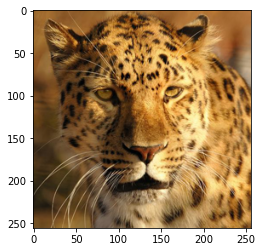

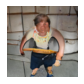

In [13]:
print("original image")
plt.imshow(target)
print("recreated image")
show_images(img.to('cpu'))

Not too succesful :(

## Conclusion

Overall, the final recronstruction technique was not succesful. There are a few things which might have gone wrong. Most obviously, the decoding into brain space seems to be bugged, this will require further consideration. As well, the vectorizer using pretrained mobile net seems fishy and needs to be looked at. Overall, this is a very challenging problem which demands perfection in all respects of the problem. 

The results that I did get suggested that direct reconstruction was able to capture shape and color to some degree. This clearly shows that visual information is being encoded in the brain. The problem is that there is still much work to be done in order to fully extract this information. 

What we did find out though is that feature extraction is a useful step, particularly SRMs are very helpful. Further, we know that is is possible to recreate images using a GAN and a target. This provides motivation for continuing the work here and fixing the process. 

I still firmly believe that the method I am going through here is the most effective one. There are just a few things which need to be ironed out. I look forward to continuing this work after the conclusion of this class. 

Overall, this was an extremeley educational and fun assignment and a great class. Thank you very much for facilitating my growth and learning!